# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
import numpy as np
import pandas as pd
import os, shutil, urllib
import matplotlib.pyplot as plt
import keras
#import rasterio
#from keras_unet.models import satellite_unet
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive//My Drive/TreeID')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.
/content/drive/My Drive/TreeID/keras-retinanet
Processing /content/drive/My Drive/TreeID/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169707 sha256=12dcd1685a0301d5f6d2f052d165dd4c6f6ca38d640863321bdf5117432a4975
  Stored in directory: /root/.cache/pip/wheels/0f/75/51/7317bde002e09e27a0c203c7fa31db360bdc6d1cb32801dfc2
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=90c22339d7c29b2e6c7d11138ad4eb10a53f1a32d6e25006965dc30ca015d879
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cyt

In [3]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

## Delete certain type of files

In [ ]:
"""
%cd keras-retinanet/dataset

files = os.listdir()
tifs = [i for i in files if i.endswith('.xml')]
for f in tifs:
    os.remove(f)
"""

/content/drive/My Drive/TreeID/keras-retinanet/dataset


## Convert csv to PlumsVOC

In [4]:
! pip install pascal_voc_writer

In [17]:
os.chdir('/content/drive//My Drive/TreeID/keras-retinanet')

df = pd.read_csv("../annotations_ts1.csv")
sh = df.shape
print(sh)
print(df.head(5))
imgs = df['img'].unique()
len(imgs)

(204, 6)
                    img  xmin  ymin  xmax  ymax class
0  testset1/MLBS_10.jpg     0   149    39   196   veg
1  testset1/MLBS_10.jpg     0   104    70   197   veg
2  testset1/MLBS_10.jpg    61   131   103   175   veg
3  testset1/MLBS_10.jpg    93   117   196   197   veg
4  testset1/MLBS_10.jpg    80   163   108   196   veg


10

In [18]:
imgs[0]
imgs[0][0:-3]

'testset1/MLBS_10.'

In [19]:
from pascal_voc_writer import Writer

for i in range(len(imgs)):
    
    dfsb = df[df.img.eq(imgs[i])]
    dfsb = dfsb.reset_index()
    shape = dfsb.shape
    
    nm = imgs[i]
    writer = Writer(nm, 200, 200)
    
    for j in range(shape[0]):
        
        xmin = dfsb['xmin'][j]
        xmax = dfsb['xmax'][j]
        ymin = dfsb['ymin'][j]
        ymax = dfsb['ymax'][j]
        
        writer.addObject(dfsb['class'][j],xmin, ymin, xmax, ymax)
    
    nm2 = dfsb['img'][1][0:-3] + 'xml'
    writer.save(nm2)

In [20]:
!pwd

/content/drive/My Drive/TreeID/keras-retinanet


# Training Model

Download pretrained model and run training.

In the next cell choose one option:

1.   download Fizyr Resnet50 pretrained model
2.   download your custom pretrained model, to continue previous training epochs

In the last cell optionally export trained model to Google Drive.


In [21]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
os.chdir('/content/drive/My Drive/TreeID/keras-retinanet')

In [22]:
!pip install keras_resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=ed4c60136be4ad9718e41806eec199488543117f8b171a75dc5617a52ce7197c
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [23]:
import keras_retinanet
import keras_resnet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
#from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.models import load_model
# import miscellaneous modules
import cv2
import time

In [ ]:
!python3 keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 10 --steps 200 --epochs 50 csv annotations_tr1.csv classes.csv

Using TensorFlow backend.
2020-06-29 00:20:28.264488: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-06-29 00:21:17.412568: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-29 00:21:17.479808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-29 00:21:17.480474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-29 00:21:17.480525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-

In [ ]:
#### OPTIONAL: EXPORT TRAINED MODEL TO DRIVE ####
drive.mount('/content/gdrive')
COLAB_MODEL = './snapshots/resnet50_csv_10.h5'
DRIVE_DIR = '/content/gdrive/My Drive/Colab Notebooks/'
shutil.copy(COLAB_MODEL, DRIVE_DIR)

Mounted at /content/gdrive


OSError: ignored

# Convert trained model into inference model



In [ ]:
os.chdir('/content/drive/My Drive/TreeID/keras-retinanet')
PRETRAINED_MODEL = './snapshots/resnet50_csv_10.h5'
!python3 keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/model10.h5

from keras_retinanet.models import load_model
model = load_model(PRETRAINED_MODEL, backbone_name='resnet50')
model = models.convert_model(model)

Using TensorFlow backend.
2020-06-28 21:28:43.007568: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-28 21:28:44.592492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-28 21:28:44.595047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-28 21:28:44.595572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-06-28 21:28:44.595606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-28 21:28:44.597457: I ten

# Inference
Run inference with uploaded image on trained model.

In [ ]:
THRES_SCORE = 0.3

In [ ]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import json
from random import shuffle
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
tf.compat.v1.keras.backend.set_session(get_session())

In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')


model = models.convert_model(model)

CLASSES_FILE = "classes.csv"
# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________

# Load image for testing

In [ ]:
# load imagery
image_dir = "dataset/"

image_list = []
for root, dirs, files in os.walk(image_dir):  
    for filename in files:
        if filename.lower().endswith(('.jpg')):
            image_list.append(image_dir + filename)
print(len(image_list))

82


# Run detections on all tiles



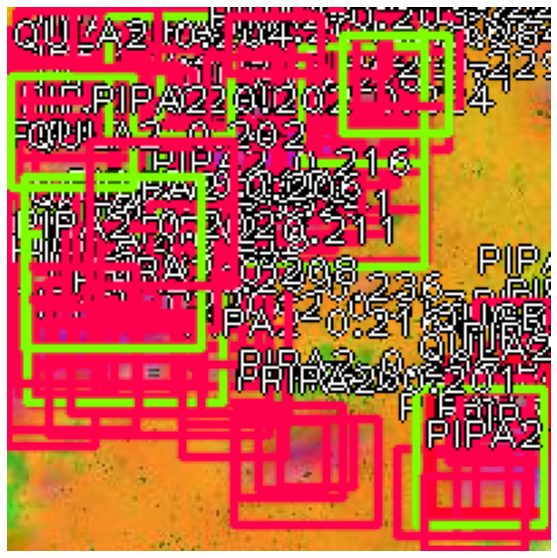

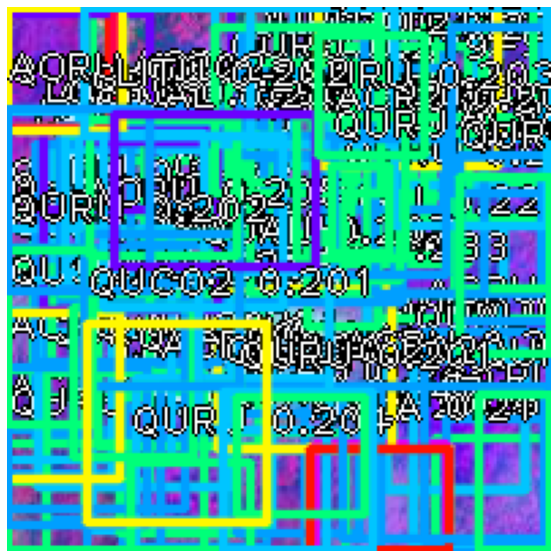

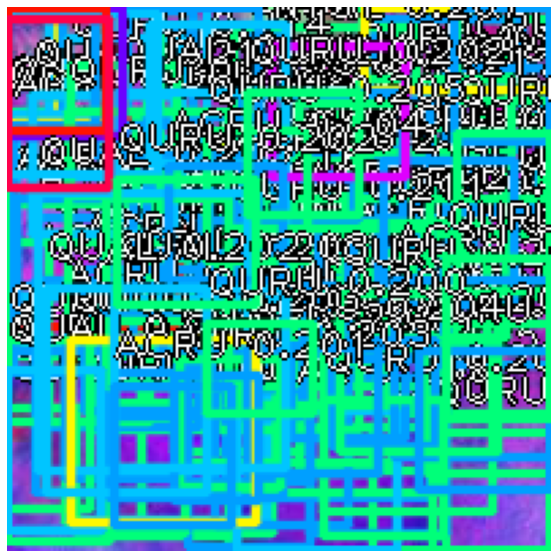

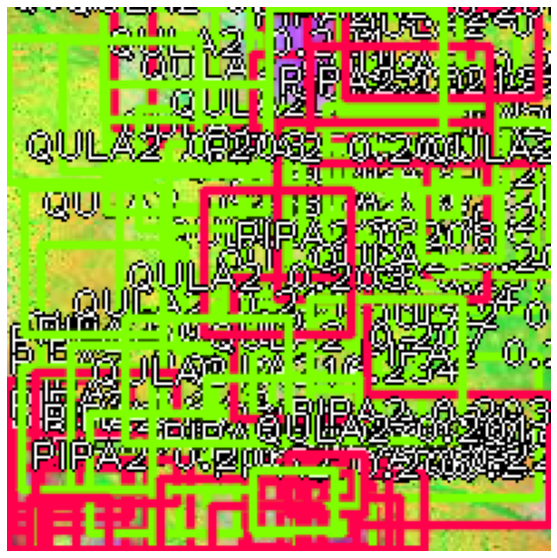

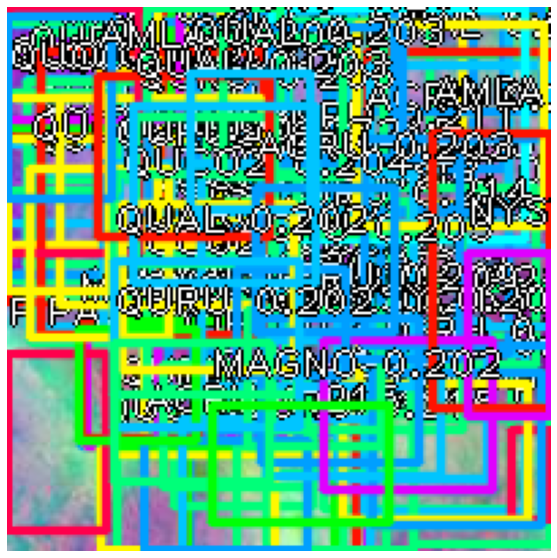

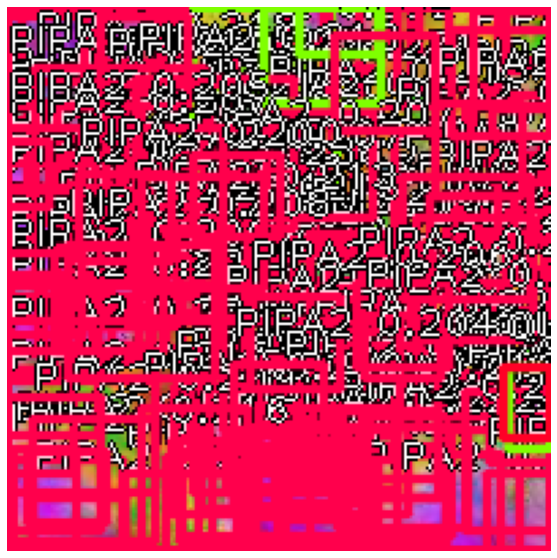

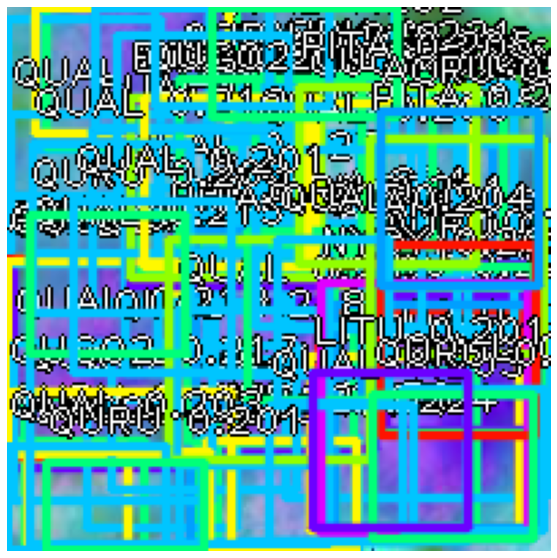

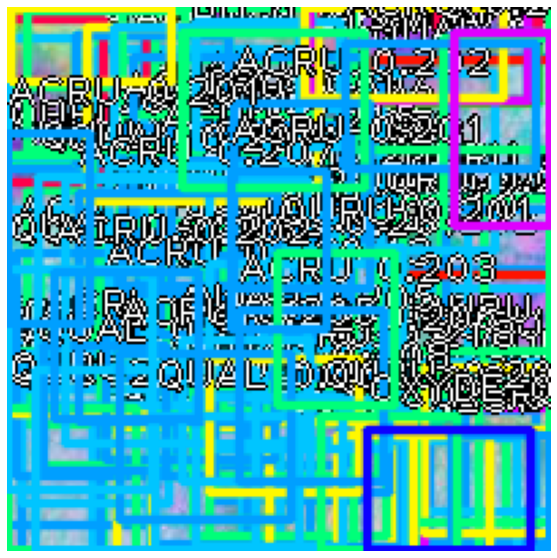

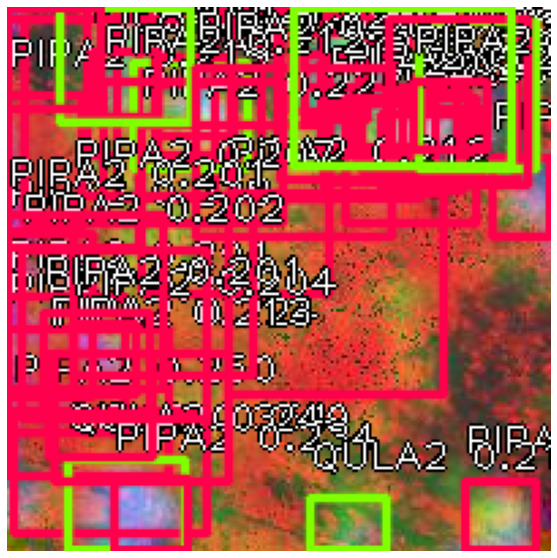

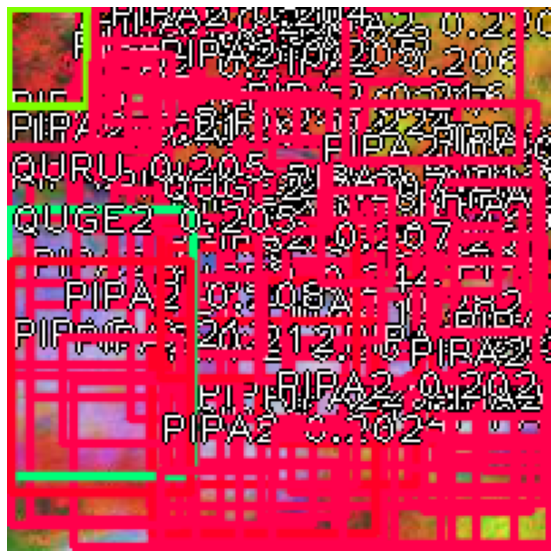

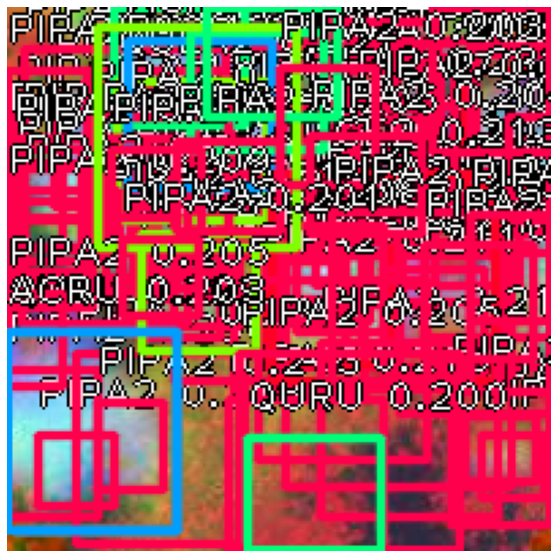

Finished, time per image: 0.042131406504933425


In [ ]:
min_score = 0.2 # this is the CNN's confidence that the detection is correct
detection_iterations = 10 # max number of images to visualize

visualize = True

detections = {}

total_time = 0

count = 0
shuffle(image_list)

for image_path in image_list:
    if count > detection_iterations:
        break
    else:
        count +=1
        
    image = read_image_bgr(image_path)

    if visualize:
        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start

    # correct for image scale
    boxes /= scale
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < min_score:
            break

        #print(score)
        #print(box)

        # TODO this does create a slight error in the boxes, might be worth doing something like
        # list(map(str, box) but then would need to cast on the other end back to float
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})

        if visualize:
            color = label_color(label)

            # b = box.astype(int)
            draw_box(draw, b, color=color)

            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)

    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
    
print("Finished, time per image:", total_time/len(image_list))

# Run evaluation on all test data to get overall accuracy



In [ ]:
!python3 keras_retinanet/bin/evaluate.py csv annotations.csv classes.csv snapshots/model10.h5

Using TensorFlow backend.
2020-06-28 21:30:40.759670: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Loading model, this may take a second...
2020-06-28 21:30:42.856477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-28 21:30:42.859351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-28 21:30:42.859869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-06-28 21:30:42.859903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.

In [ ]:
#detections

{'dataset/MLBS_1.jpg': [{'box': array([ 21, 118,  93, 189]),
   'label': 30,
   'score': 0.38811797},
  {'box': array([ 70,  99, 111, 140]), 'label': 30, 'score': 0.37780347},
  {'box': array([ 92,  64, 137, 115]), 'label': 30, 'score': 0.36916417},
  {'box': array([ 90,  81, 132, 127]), 'label': 30, 'score': 0.36745504},
  {'box': array([ 97,  14, 146,  62]), 'label': 30, 'score': 0.3655018},
  {'box': array([ 97,  14, 146,  62]), 'label': 1, 'score': 0.3335576},
  {'box': array([  0,  38,  66, 128]), 'label': 30, 'score': 0.32708082},
  {'box': array([125,  84, 161, 127]), 'label': 30, 'score': 0.32126057},
  {'box': array([ 81, 154, 134, 199]), 'label': 30, 'score': 0.32026517},
  {'box': array([ 49, 132,  97, 193]), 'label': 1, 'score': 0.32006532},
  {'box': array([132,  53, 171,  96]), 'label': 30, 'score': 0.31600982},
  {'box': array([ 82, 137, 161, 199]), 'label': 30, 'score': 0.31479305},
  {'box': array([ 52,   9, 102,  61]), 'label': 30, 'score': 0.3138492},
  {'box': array

# Run detection on uploaded data

In [ ]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      print(caption)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [ ]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
with open('data/new_detections.json', 'w') as fp:
    json.dump(detections, fp, cls=MyEncoder)

Saving OSBS_13.jpg to OSBS_13.jpg
Running inference on: OSBS_13.jpg
processing time:  0.33225440979003906
PIPA2 0.576
PIPA2 0.540
PIPA2 0.525
PIPA2 0.344
PIPA2 0.304
PIPA2 0.304


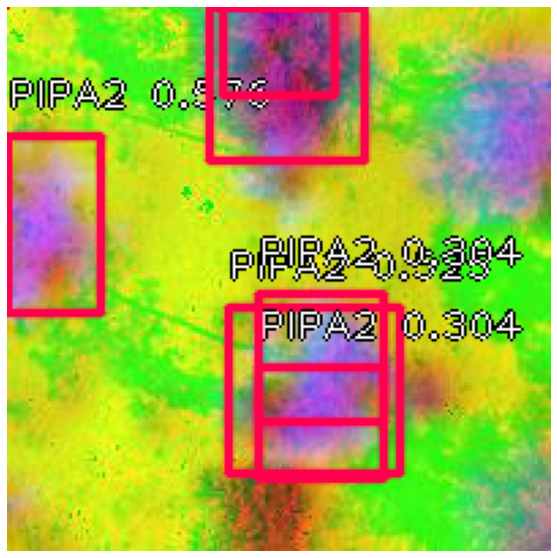

In [ ]:
uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)